# Machine Learning Trading Bot

#### Tune the Baseline Trading Algorithm

Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

In [55]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [56]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [57]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [58]:
# Set the short window and long window
short_window = 10
long_window = 125

# Generate the fast and slow simple moving averages (10 and 125 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-09 14:30:00,25.82,0.000775,25.758,24.54056
2015-04-10 09:45:00,25.83,0.000387,25.767,24.55536
2015-04-10 10:00:00,25.81,-0.000774,25.778,24.56648
2015-04-10 10:30:00,25.84,0.001162,25.792,24.57768
2015-04-10 10:45:00,25.79,-0.001935,25.803,24.58832


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,29.96740
2021-01-22 11:30:00,33.35,0.002405,33.014,30.00948
2021-01-22 13:45:00,33.42,0.002099,33.098,30.05284
2021-01-22 14:30:00,33.47,0.001496,33.170,30.09716
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.14116


In [59]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-09 14:30:00,25.82,0.000775,25.758,24.54056,1.0
2015-04-10 09:45:00,25.83,0.000387,25.767,24.55536,1.0
2015-04-10 10:00:00,25.81,-0.000774,25.778,24.56648,-1.0
2015-04-10 10:30:00,25.84,0.001162,25.792,24.57768,1.0
2015-04-10 10:45:00,25.79,-0.001935,25.803,24.58832,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,29.96740,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.014,30.00948,1.0
2021-01-22 13:45:00,33.42,0.002099,33.098,30.05284,1.0
2021-01-22 14:30:00,33.47,0.001496,33.170,30.09716,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.14116,-1.0


In [60]:
signals_df['Signal'].value_counts()

 1.0    2350
-1.0    1848
Name: Signal, dtype: int64

In [61]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-09 14:30:00,25.82,0.000775,25.758,24.54056,1.0,NaN
2015-04-10 09:45:00,25.83,0.000387,25.767,24.55536,1.0,0.000387
2015-04-10 10:00:00,25.81,-0.000774,25.778,24.56648,-1.0,-0.000774
2015-04-10 10:30:00,25.84,0.001162,25.792,24.57768,1.0,-0.001162
2015-04-10 10:45:00,25.79,-0.001935,25.803,24.58832,-1.0,-0.001935


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,29.96740,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.014,30.00948,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.098,30.05284,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.170,30.09716,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.14116,-1.0,-0.000896


<AxesSubplot: xlabel='date'>

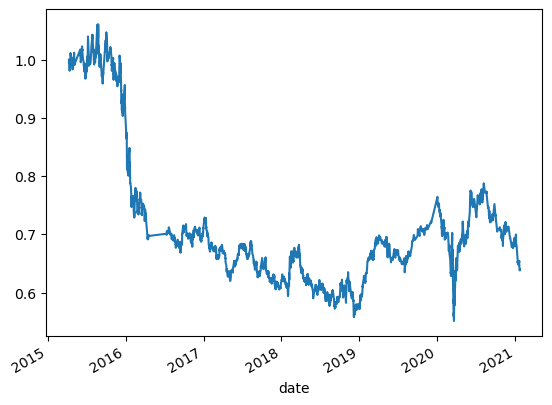

In [62]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [63]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-10 09:45:00,25.758,24.54056
2015-04-10 10:00:00,25.767,24.55536
2015-04-10 10:30:00,25.778,24.56648
2015-04-10 10:45:00,25.792,24.57768
2015-04-10 11:30:00,25.803,24.58832


In [64]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2350
-1.0    1848
Name: Signal, dtype: int64

In [65]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-10 09:45:00


In [66]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-10 09:45:00


In [67]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-10 09:45:00,25.758,24.54056
2015-04-10 10:00:00,25.767,24.55536
2015-04-10 10:30:00,25.778,24.56648
2015-04-10 10:45:00,25.792,24.57768
2015-04-10 11:30:00,25.803,24.58832


In [68]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-10 09:45:00,25.758,24.54056
2015-04-10 10:00:00,25.767,24.55536
2015-04-10 10:30:00,25.778,24.56648
2015-04-10 10:45:00,25.792,24.57768
2015-04-10 11:30:00,25.803,24.58832


In [69]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [70]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([-1., -1., -1., ...,  1.,  1.,  1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [71]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.01      0.02      1793
         1.0       0.56      0.99      0.72      2284

    accuracy                           0.56      4077
   macro avg       0.52      0.50      0.37      4077
weighted avg       0.52      0.56      0.41      4077



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [72]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df['Actual Returns'] * predictions_df['Predicted']
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-14 09:45:00,-1.0,0.046366,-0.046366
2015-07-14 10:00:00,-1.0,-0.000852,0.000852
2015-07-14 10:45:00,-1.0,0.000853,-0.000853
2015-07-14 11:15:00,-1.0,0.002556,-0.002556
2015-07-14 11:30:00,-1.0,0.000425,-0.000425


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

In [73]:
# Calculate and plot the cumulative returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)